The shape of our features is: (215, 6)


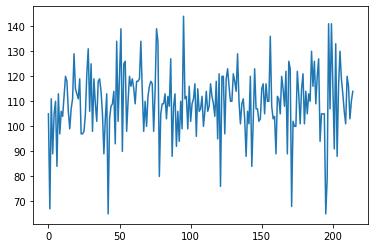

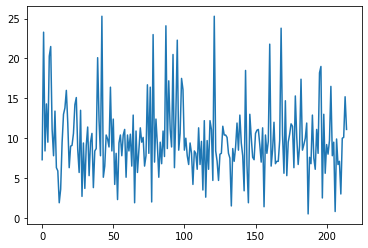

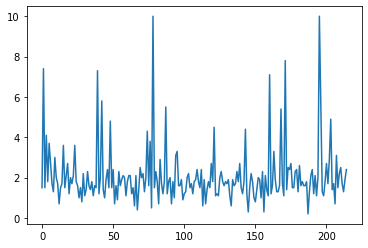

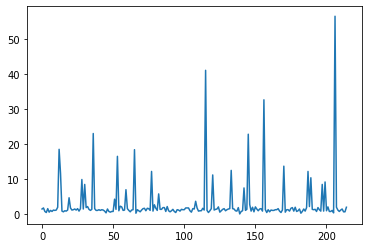

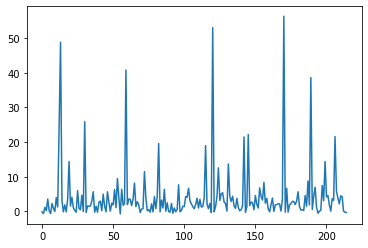

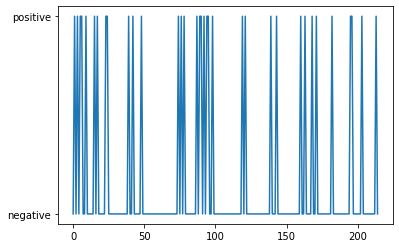

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 

PATH = r'~/documents/personal/repos/class-imbalance/data/thyroid.csv'

data = pd.read_csv(PATH)

print(f'The shape of our features is: {data.shape}')
data.describe()

def create_plot(x, y):
    plt.plot(x, y)
    plt.show()


for col in data.columns:
    create_plot(data.index, data[col])

Ideas:
- Read in the data
- Create baseline random forest model on the data
    - What are the performance metrics used for this?
    - ROC AUC?
    - Precision?
    - Recall
    - F score?
- Apply random oversampling
- Apply SMOTE
- Apply ADASYN
- Apply combination of SMOTE with random undersampling
- Apply combination of ADASYN with random undersampling

In [2]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split

# target = 'Class'
# 
# X = data.drop(target, axis=1)
# y = data.loc[:, target]
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X, y = make_classification(n_samples=2000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=4)

# plt.plot(y, X[:, 0])
# plt.show()
# 
# plt.plot(y, X[:, 1])
# plt.show()

model = RandomForestClassifier(n_estimators=10)
# model.fit(X_train, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', n_jobs=1)
print(f'Mean ROC AUC: {mean(scores)}')

Mean ROC AUC: 0.6832070707070708


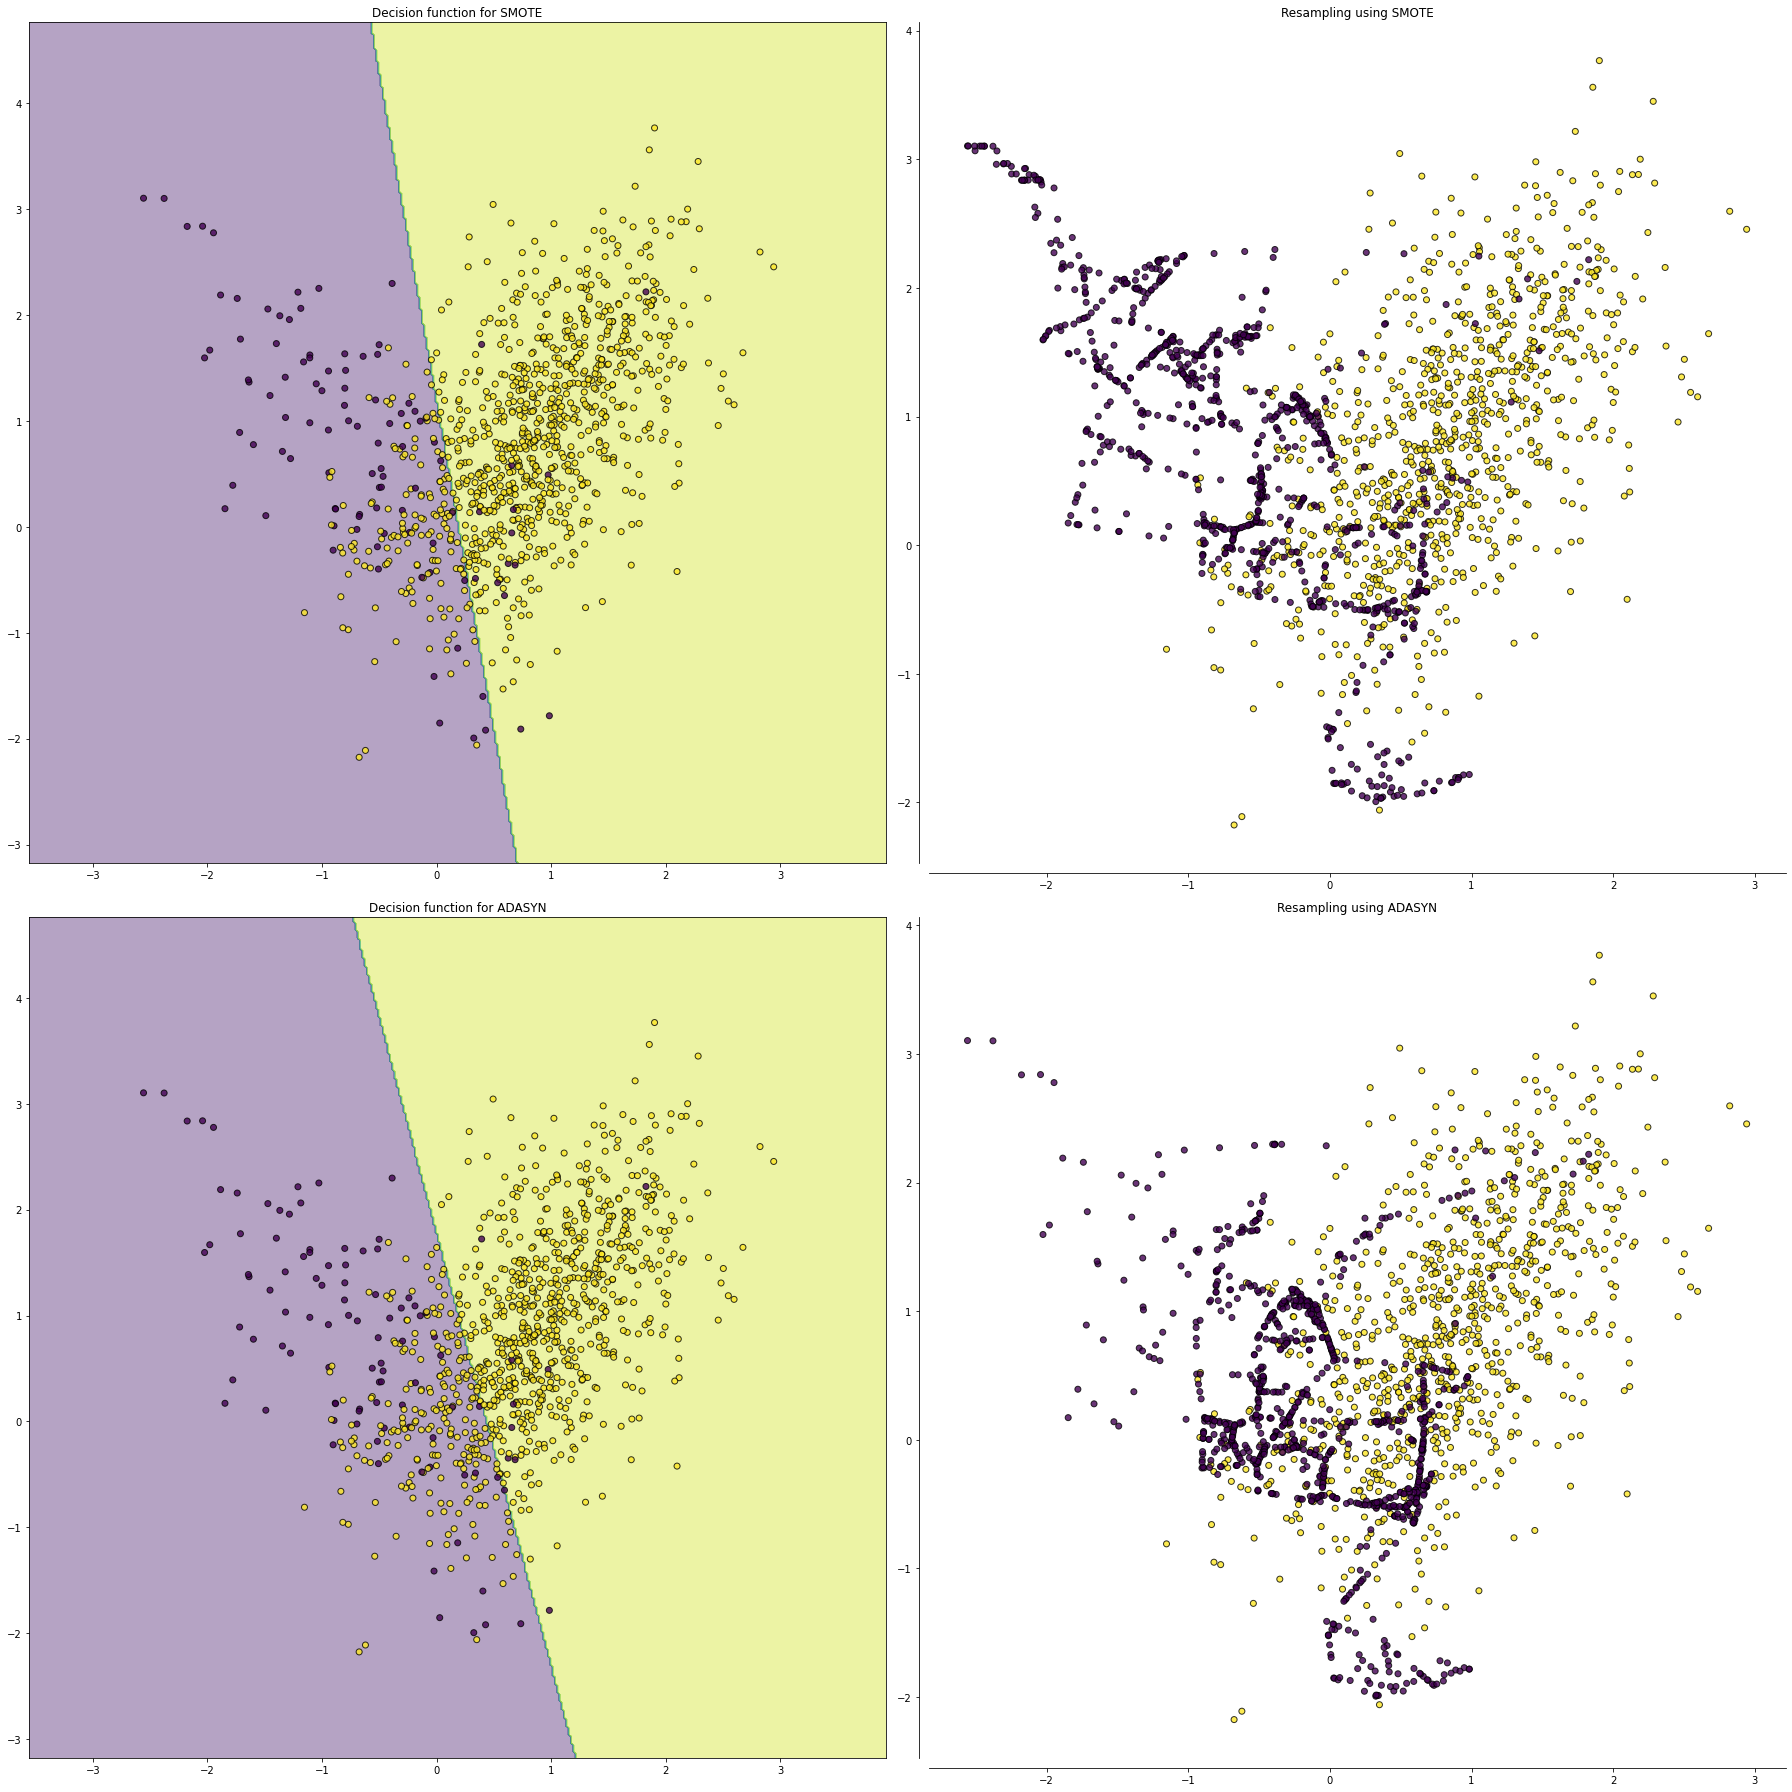

In [3]:
import numpy as np

from collections import Counter

from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

def create_dataset(
        n_samples=1000, 
        weights=(0.01, 0.99), 
        n_classes=2,
        class_sep=0.8, 
        n_clusters=1
    ):
    return make_classification(
        n_samples=n_samples, 
        n_features=2,
        n_informative=2, 
        n_redundant=0, 
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep, 
        random_state=0
    )

def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))

X, y = create_dataset(n_samples=1000, weights=(0.1, 0.99), n_classes=2)

ax_arr = ((ax1, ax2), (ax3, ax4))

for ax, sampler in zip(ax_arr, (
        SMOTE(random_state=0),
        ADASYN(random_state=0),
    )
):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

plt.savefig(r'/Users/sterling.blood@divvypay.com/Documents/Personal/Repos/class-imbalance/figs/test.png')
plt.show()

[0.40158674 0.59841326]


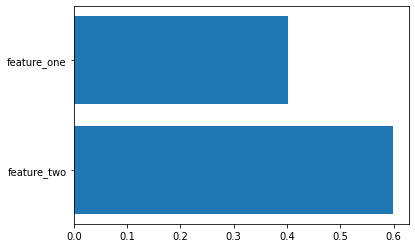

In [4]:
import pandas as pd

# Random Forest variable importance

X, y = make_classification(n_samples=2000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=4)

model = RandomForestClassifier(n_estimators=10)
model.fit(X, y)

print(model.feature_importances_)

feature_importances = pd.DataFrame(model.feature_importances_, index=['feature_one', 'feature_two'], columns=['importance']).sort_values('importance', ascending=False)
plt.barh(feature_importances.index, feature_importances.importance)
plt.show()

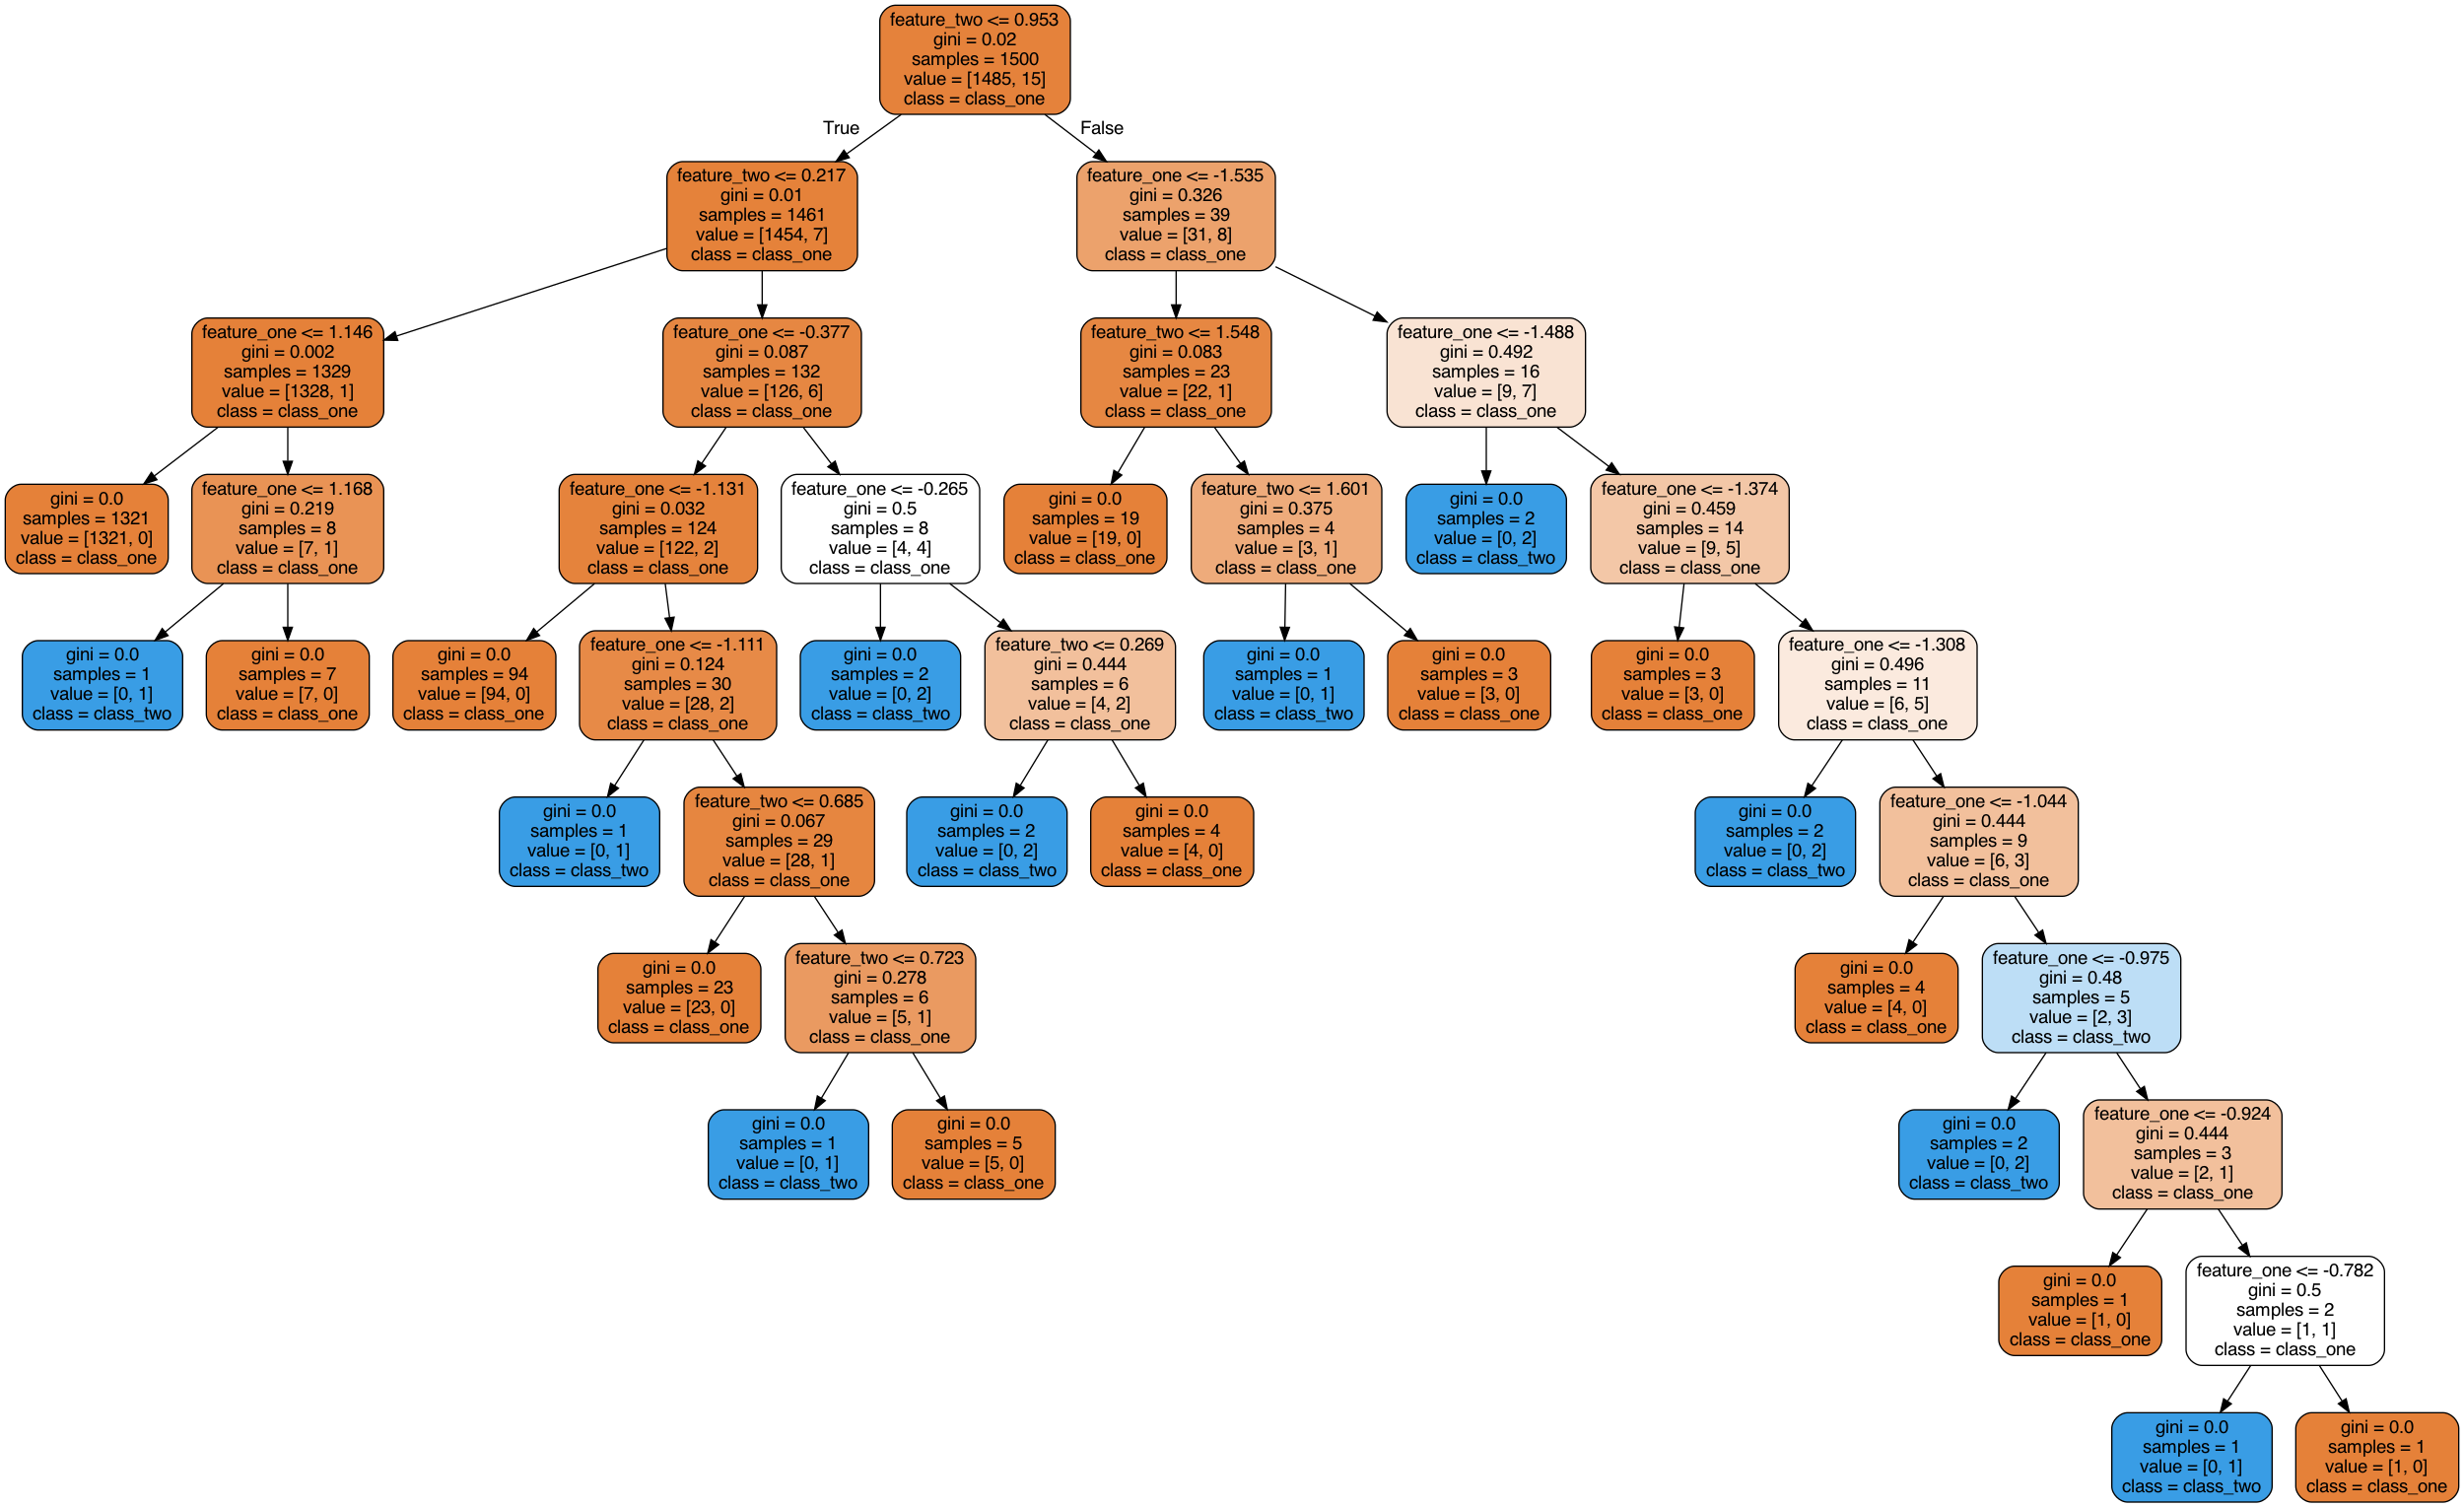

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Fit a decision tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dot_data = export_graphviz(dt, out_file=None,
                      feature_names=['feature_one', 'feature_two'],
                      class_names=['class_one', 'class_two'],
                      rounded=True,
                      filled=True,
)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

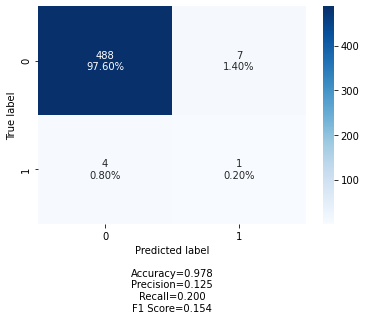

In [6]:
from sklearn.metrics import confusion_matrix

# Confusion matrix

cf_matrix = confusion_matrix(y_test, dt.predict(X_test))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
        
make_confusion_matrix(cf_matrix)